In [1]:
# libraries

import numpy as np
import pandas as pd
from matplotlib import dates
from pylab import rcParams
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.statespace.tools import diff
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


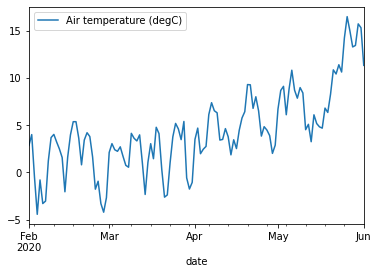

In [44]:
# download data and parse date to datetime

df_ym = pd.read_csv('espoo_2020_2022.csv',
                 parse_dates= {"date" : ["Year","m","d"]},
                keep_date_col=True)

df_ym2 = df_ym.groupby(['date']).mean()

df_ym2.index.freq = "D"

df_final = df_ym2['2020-02-01':'2020-06-01']

df_final.plot();

In [3]:
# rename column

#df['Temperature (C)'] = df['Air temperature (degC)']
#df.drop(['Air temperature (degC)'],axis=1, inplace=True)

In [4]:
# create training and test sets

df_train = df.iloc[:586]
df_test = df.iloc[585:]

In [5]:
# fit model

fitted_model = ExponentialSmoothing(df_train['Air temperature (degC)'],trend='add',seasonal='add',seasonal_periods=100).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [6]:
# make forecasting

test_predictions = fitted_model.forecast(148).rename('Forecast')

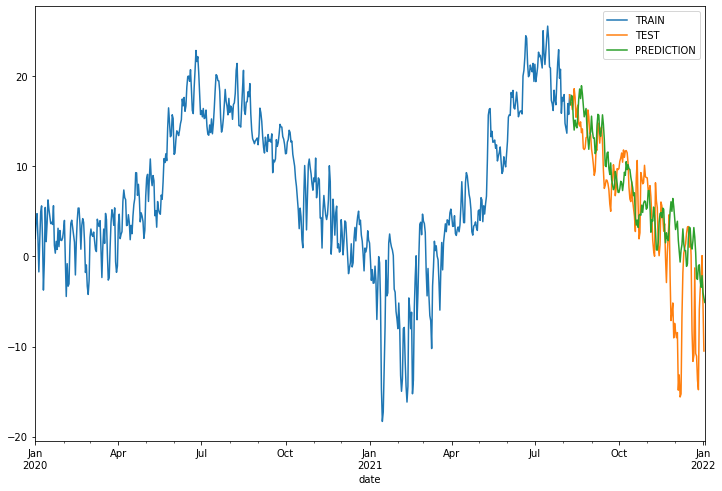

In [7]:
# plot forecasting and observations

df_train['Air temperature (degC)'].plot(legend=True,label='TRAIN')
df_test['Air temperature (degC)'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION');

Evaluation

In [8]:
# MAE
# Disadvantage: does not tell when it is completely off

mean_absolute_error(df_test,test_predictions)

3.660096538322963

In [9]:
# MSE
# Disadvantage: units are squared

mean_squared_error(df_test,test_predictions)

28.04966471246905

In [10]:
# RMSE

np.sqrt(mean_squared_error(df_test,test_predictions))

5.296193417207216

Stationarity and differencing

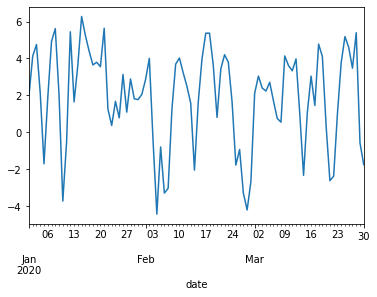

In [11]:
# extract part of the data which is stationary

df_s = df.iloc[:90]

df_s['Air temperature (degC)'].plot();

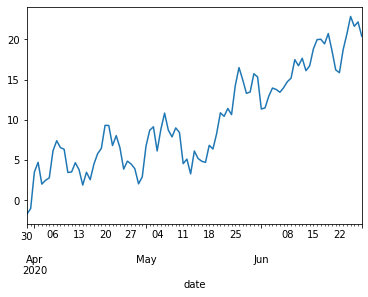

In [12]:
# non-stationary data

df_ns = df.iloc[89:180]

df_ns['Air temperature (degC)'].plot();

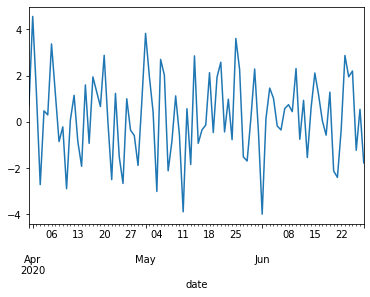

In [13]:
# create stationary data from non-stationary using first order differencing

diff(df_ns['Air temperature (degC)'],k_diff = 1).plot()

Autocorrelation plot (ACF) and Partial Autocorrelation plot (PACF)

In [14]:
import statsmodels.api as sm

from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols

In [15]:
# ignore harmless warnings

import warnings
warnings.filterwarnings("ignore")

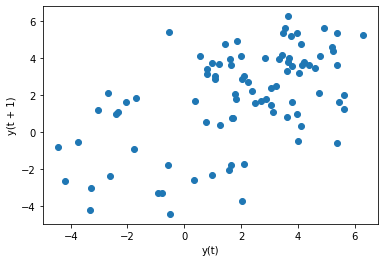

In [16]:
# non-stationary -> no much correalation

from pandas.plotting import lag_plot

lag_plot(df_s['Air temperature (degC)']);

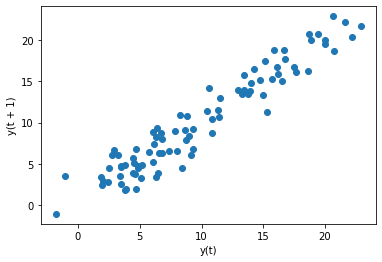

In [17]:
# stationary data -> correlation due to the e.g. seasonality

lag_plot(df_ns['Air temperature (degC)']);

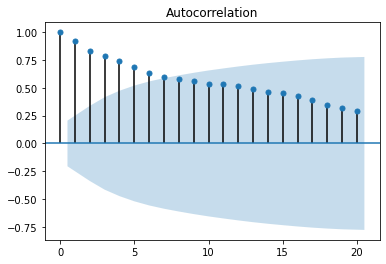

In [28]:
# ACF plots - non-stationary data

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

#df.plot();

plot_acf(df_ns);

# shaded area -> confidence interval (which is not shaded)

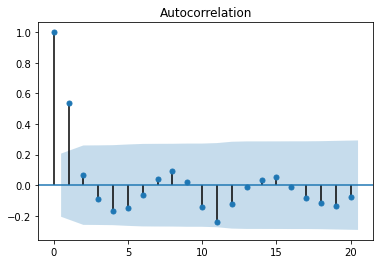

In [29]:
# ACF plots - stationary data

plot_acf(df_s);

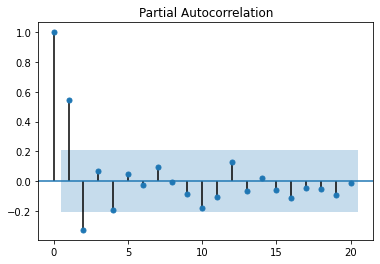

In [31]:
# PACF - stationary data

plot_pacf(df_s);

ARIMA

AutoRegressive Integrated Moving Average

In [ ]:
# ARIMA is a generalization of ARMA model
# not capable to perfectly predict any TS data e.g. stock data
# works good when data is directly related to the time stamp

# Major components of ARIMA:
#  - non seasonal (non-negative p (autoregression - regression model,
#                   d (integrated - making non-stationary to be stationary through differencing),
#                   q (moving average))

# check stationarity: Augmented Dickey-Fuller test

# How to decide on ARIMA components?

# first, make data to be stationary
# different approach for differencing e.g. difference by a season
# for seasonal data

# next, choice of pdq:
# 1) ACF and PACF based on viewing decay but can be difficult to read
# 2) Grid Search -> run different combinations

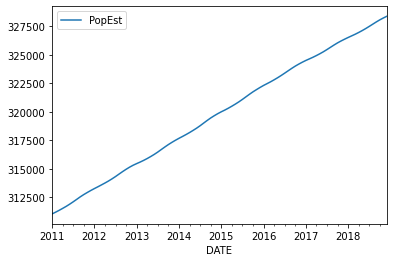

In [89]:
# AR - AutoRegression
# AR specifies that output depends linearly on previous values and
# on a stochastic term
# Load the U.S. Population dataset

df = pd.read_csv('uspopulation.csv',index_col='DATE',parse_dates=True)

df.index.freq = 'MS'

df.plot();

In [96]:
# divide into training and test sets

train = df.iloc[:84]
test = df.iloc[84:]

In [97]:
# create AR model

model_ar = AR(train['PopEst'])

In [98]:
# fit the model, order=1

AR1fit = model_ar.fit(maxlag=1)

In [99]:
# criteria

AR1fit.aic

6.410771237032229

In [100]:
# parameters

AR1fit.params

const        284.913797
L1.PopEst      0.999686
dtype: float64

In [106]:
# predict

start=len(train)
end=len(train)+len(test)-1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

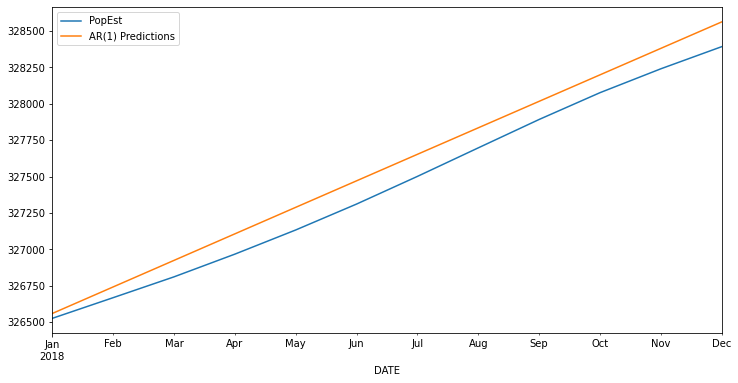

In [107]:
test['PopEst'].plot(legend=True)
predictions1.plot(legend=True,figsize=(12,6));

In [109]:
# order 2

AR2fit = model_ar.fit(maxlag=2)

predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(2) Predictions')

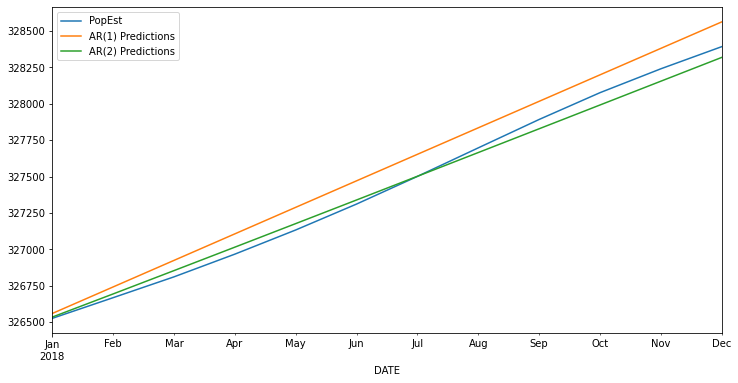

In [111]:
test['PopEst'].plot(legend=True)
predictions1.plot(legend=True,figsize=(12,6))
predictions2.plot(legend=True);

In [117]:
# define the order - ic parameter with criterion

ARfit = model_ar.fit(ic='t-stat')

predictions3 = ARfit.predict(start=start, end=end, dynamic=False).rename('AR(ic) Predictions')

# evaluate

from sklearn.metrics import mean_squared_error

preds = [predictions1, predictions2, predictions3]

labels = ['AR1','AR2','AR(ic)']

for i in range(3):
  error = mean_squared_error(test['PopEst'],preds[i])
  print(f"{labels[i]} MSE: {error}")

AR1 MSE: 17449.71423587912
AR2 MSE: 2713.2585540102214
AR(ic) MSE: 186.97053754548145


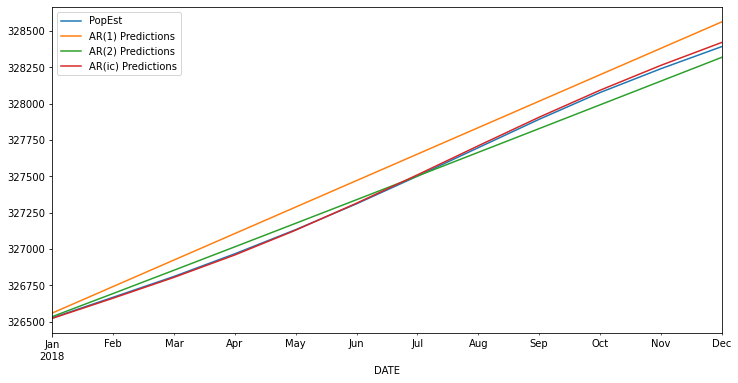

In [118]:
test['PopEst'].plot(legend=True)
predictions1.plot(legend=True,figsize=(12,6))
predictions2.plot(legend=True)
predictions3.plot(legend=True);

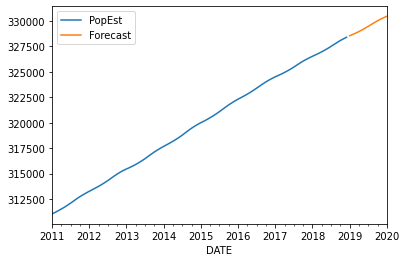

In [121]:
# forecasting

model = AR(df['PopEst'])

AR_for = model.fit()

forecast = AR_for.predict(start=len(df),end=len(df)+12).rename('Forecast')

df['PopEst'].plot(legend=True)
forecast.plot(legend=True);